In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow версія: {tf.__version__}")
print(f"Доступність GPU: {len(tf.config.list_physical_devices('GPU')) > 0}")

TensorFlow версія: 2.19.0
Доступність GPU: False


In [ ]:
def create_circle(img_size=64):
    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    center = (np.random.randint(img_size//4, 3*img_size//4),
              np.random.randint(img_size//4, 3*img_size//4))
    radius = np.random.randint(img_size//6, img_size//3)
    color = tuple(np.random.randint(100, 256, 3).tolist())
    thickness = -1  

    cv2.circle(img, center, radius, color, thickness)

    noise = np.random.normal(0, 10, img.shape)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)

    return img

def create_square(img_size=64):
    img = np.zeros((img_size, img_size, 3), dtype=np.uint8)

    side_length = np.random.randint(img_size//3, img_size//2)
    x1 = np.random.randint(img_size//8, img_size//2)
    y1 = np.random.randint(img_size//8, img_size//2)
    x2 = x1 + side_length
    y2 = y1 + side_length

    color = tuple(np.random.randint(100, 256, 3).tolist())

    cv2.rectangle(img, (x1, y1), (x2, y2), color, -1)

    # Додавання шуму
    noise = np.random.normal(0, 10, img.shape)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)

    return img

def create_dataset(n_samples=2000, img_size=64):
    X = []
    y = []

    for _ in range(n_samples):
        img = create_circle(img_size)
        X.append(img)
        y.append(0)

    for _ in range(n_samples):
        img = create_square(img_size)
        X.append(img)
        y.append(1)

    X = np.array(X)
    y = np.array(y)

    return X, y

In [ ]:
print("Створення набору даних...")
IMG_SIZE = 64
N_SAMPLES_PER_CLASS = 2000

X, y = create_dataset(n_samples=N_SAMPLES_PER_CLASS, img_size=IMG_SIZE)

print(f"Форма X: {X.shape}")
print(f"Форма y: {y.shape}")
print(f"Кількість зразків класу 0 (кола): {np.sum(y == 0)}")
print(f"Кількість зразків класу 1 (квадрати): {np.sum(y == 1)}")

Створення набору даних...
Форма X: (4000, 64, 64, 3)
Форма y: (4000,)
Кількість зразків класу 0 (кола): 2000
Кількість зразків класу 1 (квадрати): 2000


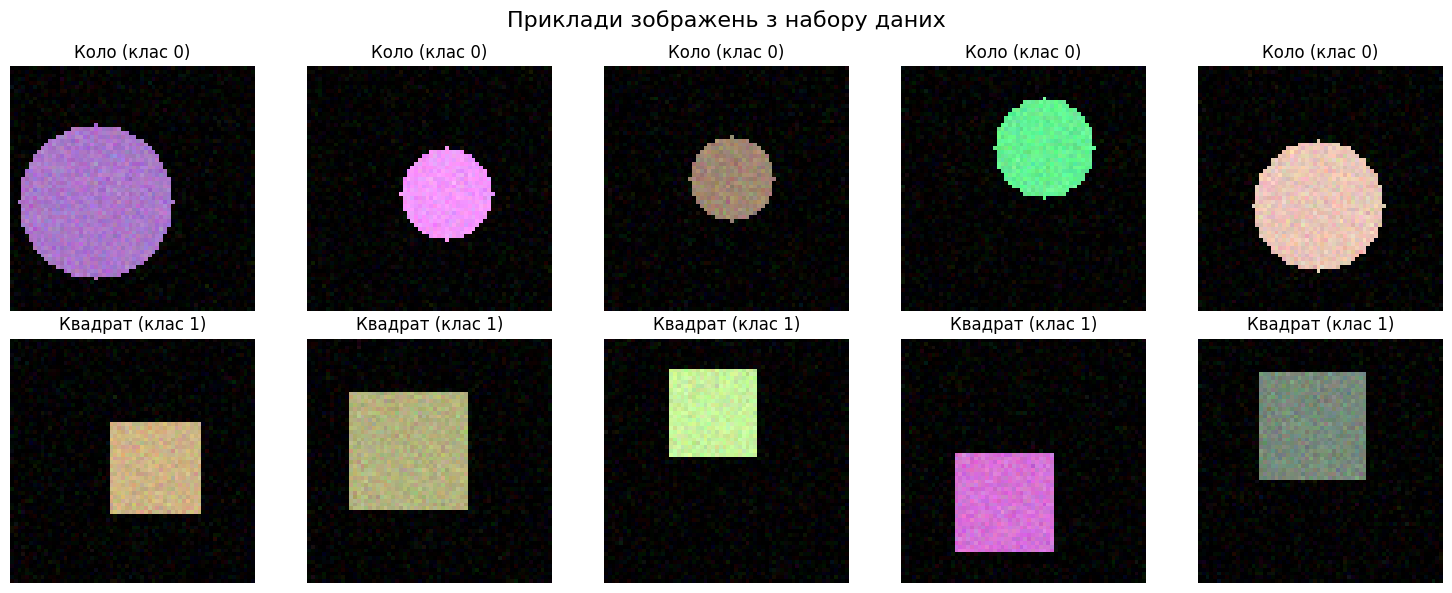

In [ ]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Приклади зображень з набору даних', fontsize=16)

circle_indices = np.where(y == 0)[0][:5]
for i, idx in enumerate(circle_indices):
    axes[0, i].imshow(X[idx])
    axes[0, i].set_title(f'Коло (клас 0)')
    axes[0, i].axis('off')

square_indices = np.where(y == 1)[0][:5]
for i, idx in enumerate(square_indices):
    axes[1, i].imshow(X[idx])
    axes[1, i].set_title(f'Квадрат (клас 1)')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X_normalized = X.astype('float32') / 255.0

X_temp, X_test, y_temp, y_test = train_test_split(
    X_normalized, y, test_size=0.15, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=42, stratify=y_temp
) 

print("Розподіл даних:")
print(f"Навчальна вибірка: {X_train.shape[0]} зразків")
print(f"Валідаційна вибірка: {X_val.shape[0]} зразків")
print(f"Тестова вибірка: {X_test.shape[0]} зразків")
print(f"\nРозподіл класів у навчальній вибірці:")
print(f"Клас 0: {np.sum(y_train == 0)} ({np.sum(y_train == 0) / len(y_train) * 100:.1f}%)")
print(f"Клас 1: {np.sum(y_train == 1)} ({np.sum(y_train == 1) / len(y_train) * 100:.1f}%)")

Розподіл даних:
Навчальна вибірка: 2801 зразків
Валідаційна вибірка: 599 зразків
Тестова вибірка: 600 зразків

Розподіл класів у навчальній вибірці:
Клас 0: 1400 (50.0%)
Клас 1: 1401 (50.0%)


In [ ]:
def create_cnn_model(input_shape=(64, 64, 3)):

    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(1, activation='sigmoid')
    ])

    return model

model = create_cnn_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,420,769 (9.23 MB)

 Trainable params: 2,419,105 (9.23 MB)

 Non-trainable params: 1,664 (6.50 KB)

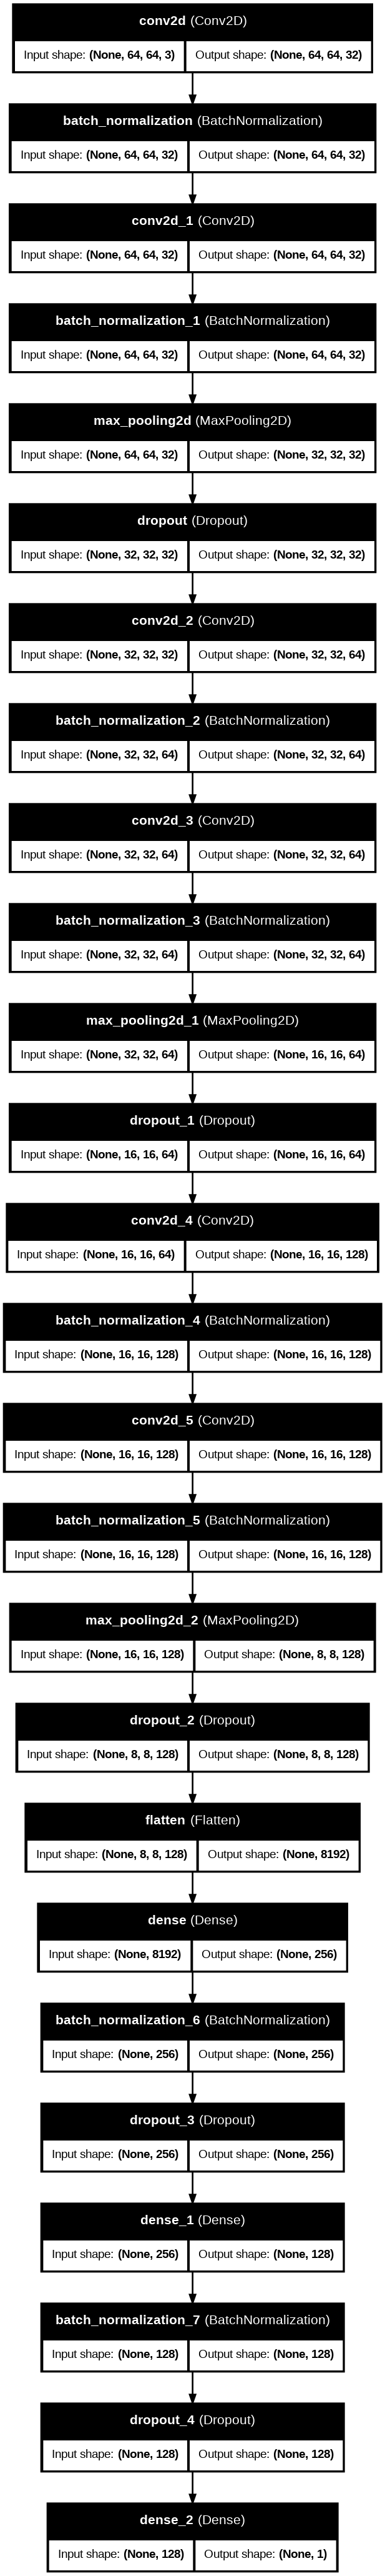

In [ ]:
keras.utils.plot_model(
    model,
    to_file='model_architecture.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB',
    dpi=96
)

from IPython.display import Image
Image('model_architecture.png')

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

print("Початок навчання моделі...")
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\nНавчання завершено!")

Початок навчання моделі...
Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.7381 - loss: 0.5962 - precision: 0.7275 - recall: 0.7375 - val_accuracy: 0.4992 - val_loss: 1.4295 - val_precision: 0.4992 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 147s 1s/step - accuracy: 0.9972 - loss: 0.0211 - precision: 0.9978 - recall: 0.9966 - val_accuracy: 0.4992 - val_loss: 1.7481 - val_precision: 0.4992 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.9979 - loss: 0.0093 - precision: 0.9990 - recall: 0.9968 - val_accuracy: 0.4992 - val_loss: 3.3879 - val_precision: 0.4992 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.9988 - loss: 0.0074 - precision: 1.0000 - recall: 0.9975 - val_accuracy: 0.4992 - val_loss: 3.6004 - val_precision: 0.4992 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 102

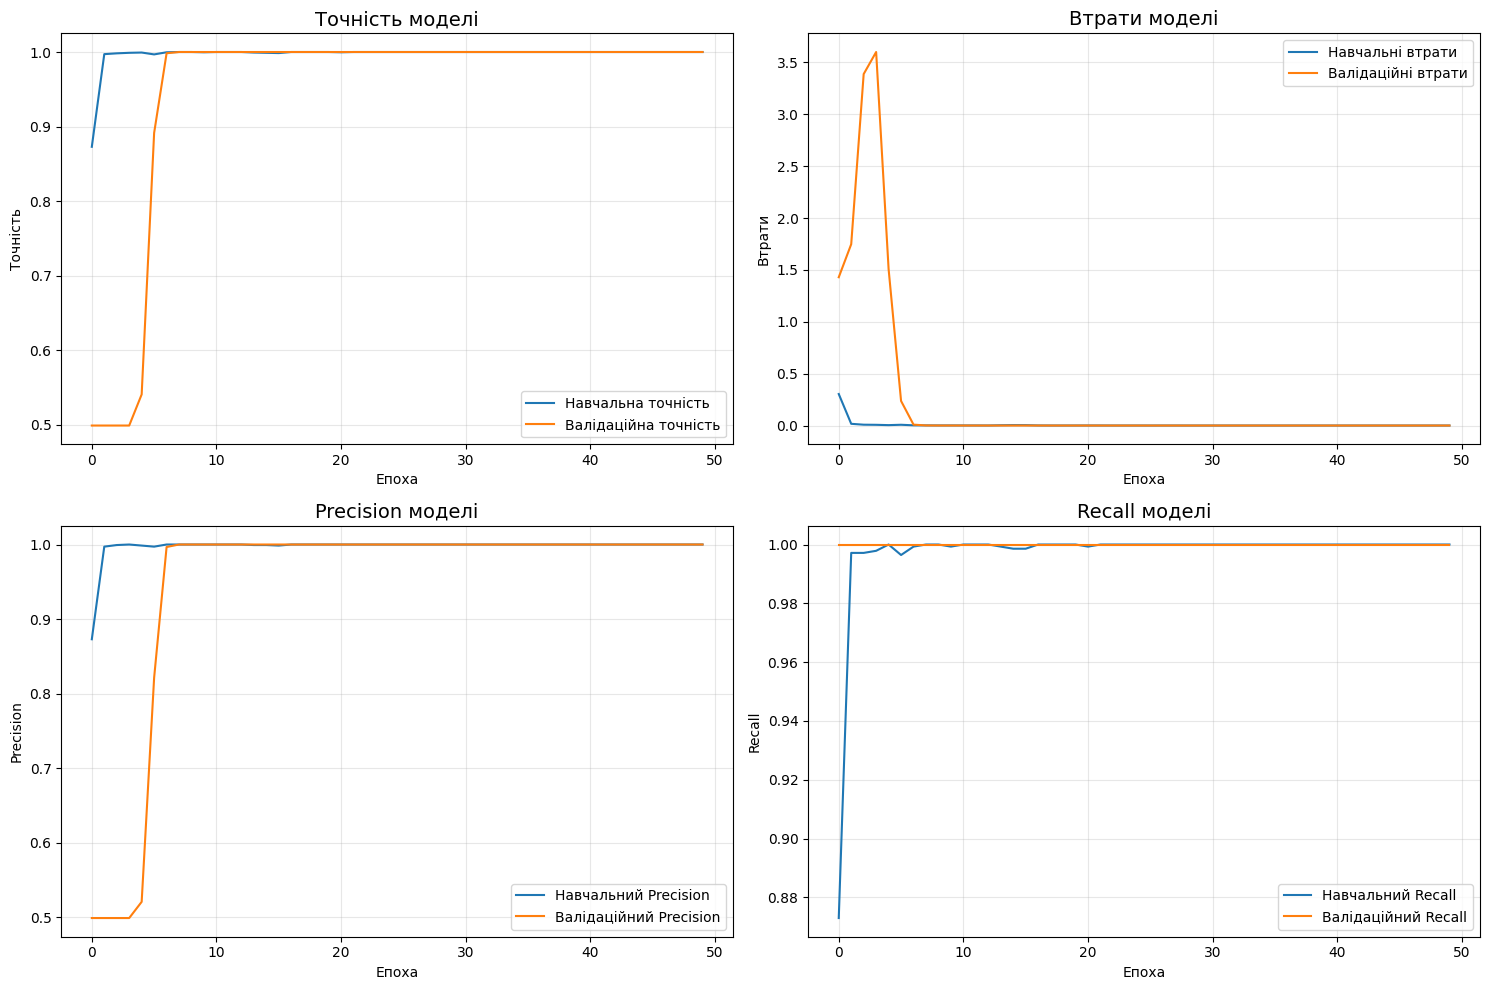

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes[0, 0].plot(history.history['accuracy'], label='Навчальна точність')
axes[0, 0].plot(history.history['val_accuracy'], label='Валідаційна точність')
axes[0, 0].set_title('Точність моделі', fontsize=14)
axes[0, 0].set_xlabel('Епоха')
axes[0, 0].set_ylabel('Точність')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(history.history['loss'], label='Навчальні втрати')
axes[0, 1].plot(history.history['val_loss'], label='Валідаційні втрати')
axes[0, 1].set_title('Втрати моделі', fontsize=14)
axes[0, 1].set_xlabel('Епоха')
axes[0, 1].set_ylabel('Втрати')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(history.history['precision'], label='Навчальний Precision')
axes[1, 0].plot(history.history['val_precision'], label='Валідаційний Precision')
axes[1, 0].set_title('Precision моделі', fontsize=14)
axes[1, 0].set_xlabel('Епоха')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(history.history['recall'], label='Навчальний Recall')
axes[1, 1].plot(history.history['val_recall'], label='Валідаційний Recall')
axes[1, 1].set_title('Recall моделі', fontsize=14)
axes[1, 1].set_xlabel('Епоха')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print("="*60)
print("РЕЗУЛЬТАТИ ОЦІНЮВАННЯ НА ТЕСТОВІЙ ВИБІРЦІ")
print("="*60)
print(f"Точність (Accuracy): {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print("="*60)

19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 208ms/step
РЕЗУЛЬТАТИ ОЦІНЮВАННЯ НА ТЕСТОВІЙ ВИБІРЦІ
Точність (Accuracy): 1.0000 (100.00%)
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000


In [ ]:
print("\nДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ:\n")
class_names = ['Коло (клас 0)', 'Квадрат (клас 1)']
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))


ДЕТАЛЬНИЙ ЗВІТ КЛАСИФІКАЦІЇ:

                  precision    recall  f1-score   support

   Коло (клас 0)     1.0000    1.0000    1.0000       300
Квадрат (клас 1)     1.0000    1.0000    1.0000       300

        accuracy                         1.0000       600
       macro avg     1.0000    1.0000    1.0000       600
    weighted avg     1.0000    1.0000    1.0000       600



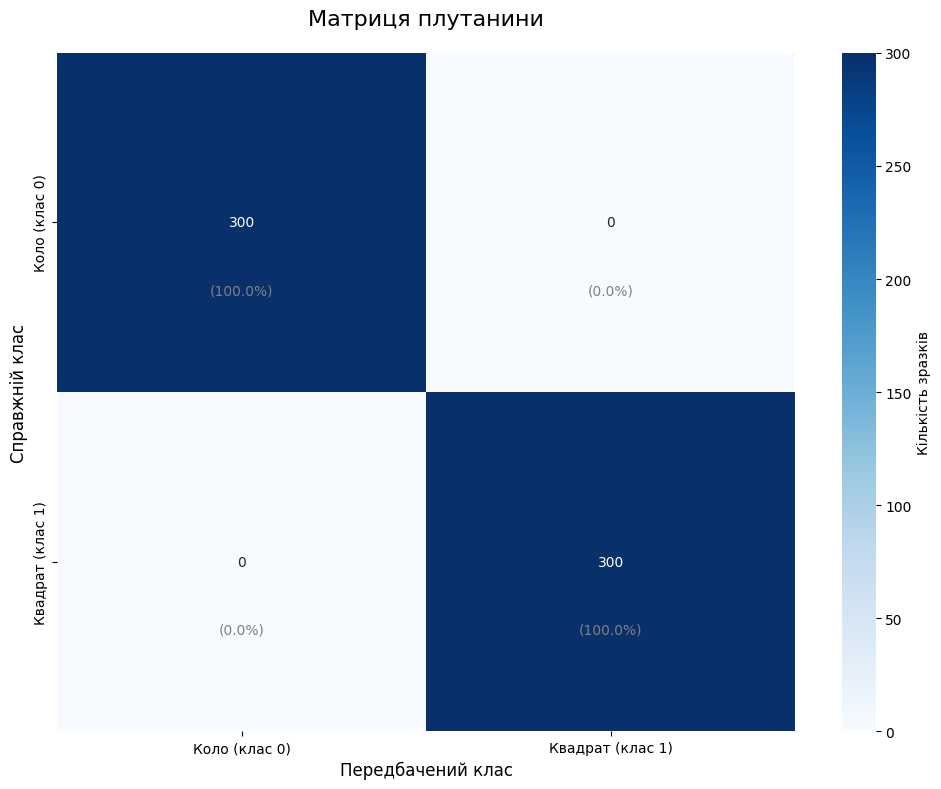


Інтерпретація матриці плутанини:
Правильно класифіковані кола (True Negatives): 300
Кола, класифіковані як квадрати (False Positives): 0
Квадрати, класифіковані як кола (False Negatives): 0
Правильно класифіковані квадрати (True Positives): 300


In [ ]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Кількість зразків'})
plt.title('Матриця плутанини', fontsize=16, pad=20)
plt.ylabel('Справжній клас', fontsize=12)
plt.xlabel('Передбачений клас', fontsize=12)

for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()

print("\nІнтерпретація матриці плутанини:")
print(f"Правильно класифіковані кола (True Negatives): {cm[0, 0]}")
print(f"Кола, класифіковані як квадрати (False Positives): {cm[0, 1]}")
print(f"Квадрати, класифіковані як кола (False Negatives): {cm[1, 0]}")
print(f"Правильно класифіковані квадрати (True Positives): {cm[1, 1]}")

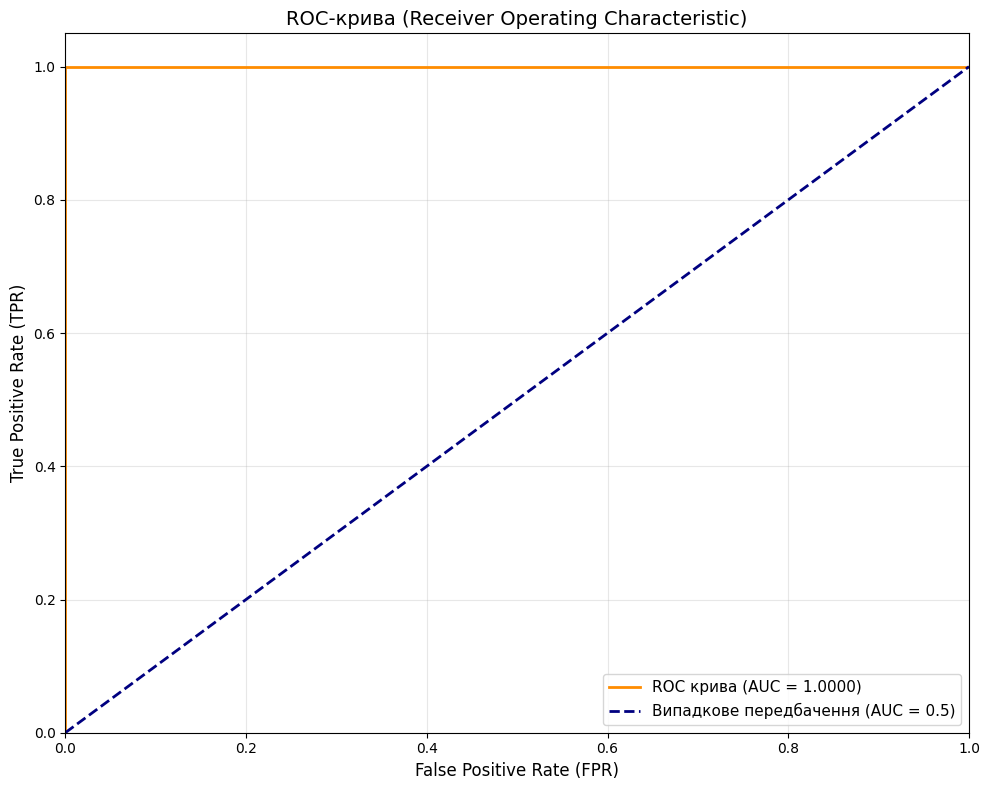


Площа під ROC-кривою (AUC): 1.0000

Інтерпретація AUC:
  Відмінна якість класифікації (AUC >= 0.9)


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC крива (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',
         label='Випадкове передбачення (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC-крива (Receiver Operating Characteristic)', fontsize=14)
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nПлоща під ROC-кривою (AUC): {roc_auc:.4f}")
print("\nІнтерпретація AUC:")
if roc_auc >= 0.9:
    print("  Відмінна якість класифікації (AUC >= 0.9)")
elif roc_auc >= 0.8:
    print("  Добра якість класифікації (0.8 <= AUC < 0.9)")
elif roc_auc >= 0.7:
    print("  Прийнятна якість класифікації (0.7 <= AUC < 0.8)")
else:
    print("  Низька якість класифікації (AUC < 0.7)")

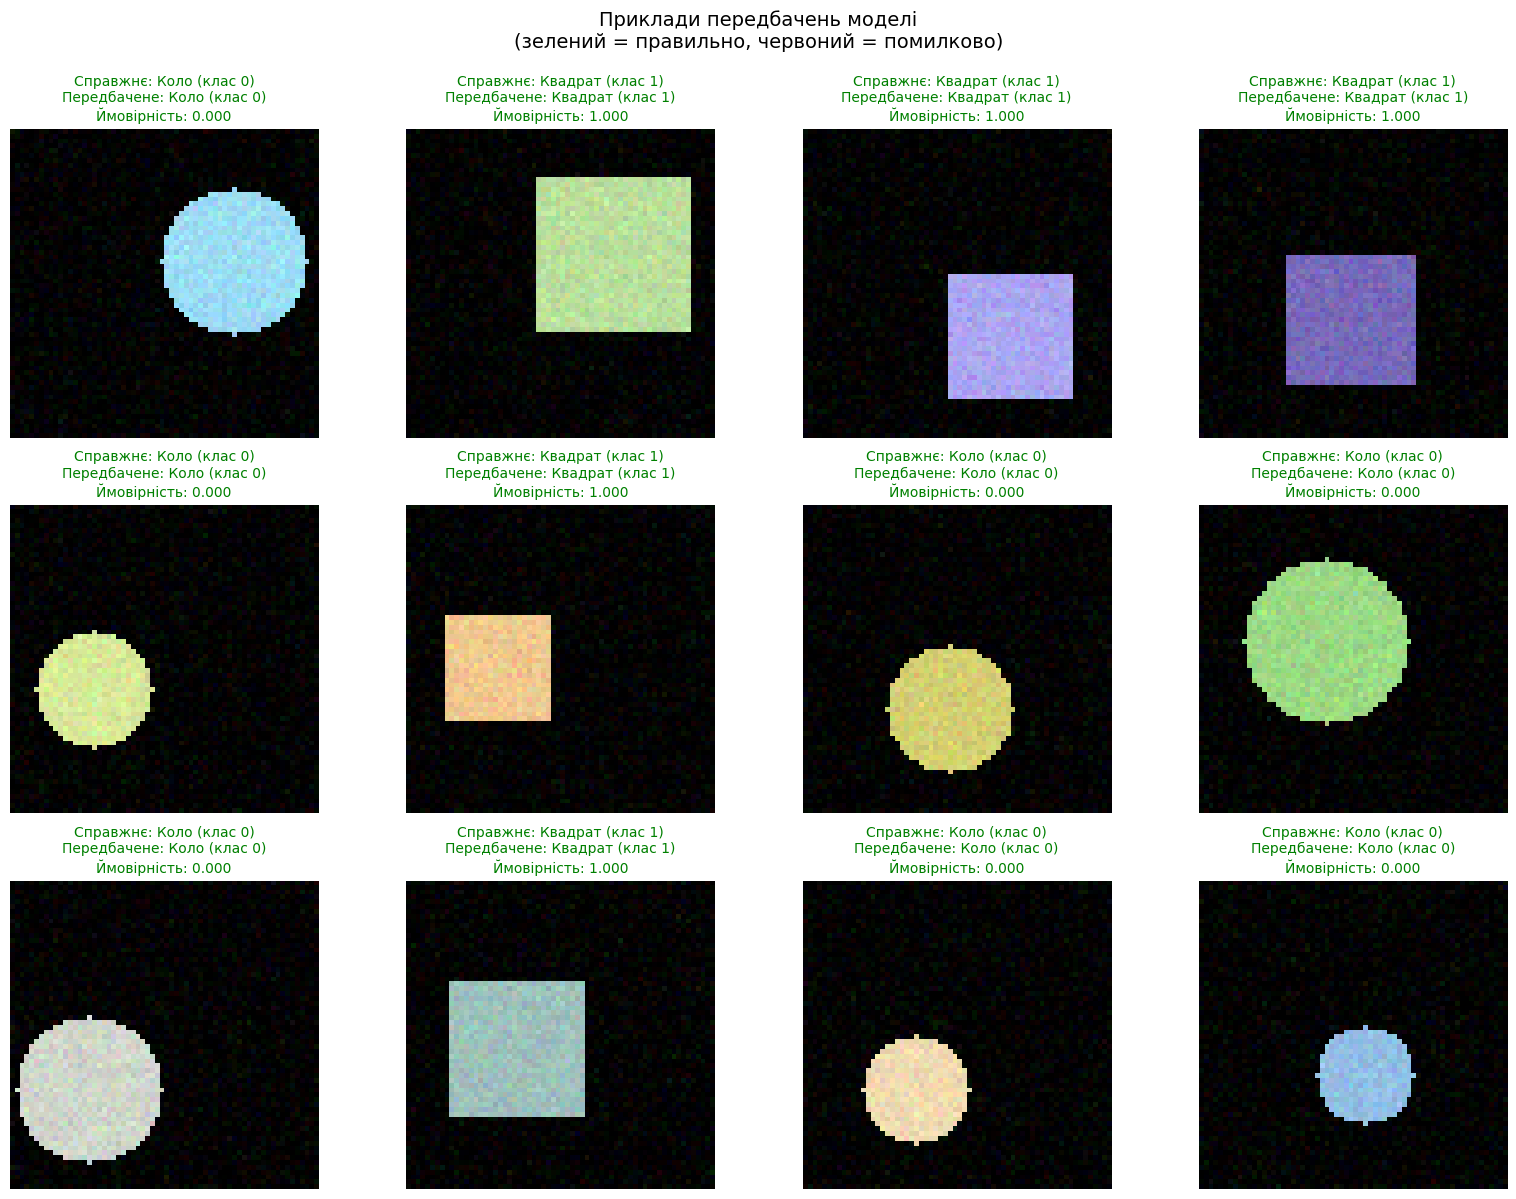

In [ ]:
n_samples_to_show = 12
random_indices = np.random.choice(len(X_test), n_samples_to_show, replace=False)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, idx in enumerate(random_indices):
    axes[i].imshow(X_test[idx])

    true_label = y_test[idx]
    pred_label = y_pred[idx]
    prob = y_pred_prob[idx][0]

    true_class = class_names[true_label]
    pred_class = class_names[pred_label]

    color = 'green' if true_label == pred_label else 'red'

    axes[i].set_title(
        f'Справжнє: {true_class}\n'
        f'Передбачене: {pred_class}\n'
        f'Ймовірність: {prob:.3f}',
        color=color, fontsize=10
    )
    axes[i].axis('off')

plt.suptitle('Приклади передбачень моделі\n(зелений = правильно, червоний = помилково)',
             fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
incorrect_indices = np.where(y_pred != y_test)[0]

print(f"Загальна кількість помилок: {len(incorrect_indices)}")
print(f"Відсоток помилок: {len(incorrect_indices) / len(y_test) * 100:.2f}%\n")

if len(incorrect_indices) > 0:
    false_positives = np.sum((y_test == 0) & (y_pred == 1))
    false_negatives = np.sum((y_test == 1) & (y_pred == 0))

    print("Розподіл помилок:")
    print(f"  False Positives (кола → квадрати): {false_positives}")
    print(f"  False Negatives (квадрати → кола): {false_negatives}")

    if len(incorrect_indices) >= 8:
        probs_incorrect = y_pred_prob[incorrect_indices].flatten()
        confidence_error = np.abs(probs_incorrect - 0.5)
        worst_errors = incorrect_indices[np.argsort(confidence_error)[-8:]]

        fig, axes = plt.subplots(2, 4, figsize=(16, 8))
        axes = axes.ravel()

        for i, idx in enumerate(worst_errors):
            axes[i].imshow(X_test[idx])

            true_label = y_test[idx]
            pred_label = y_pred[idx]
            prob = y_pred_prob[idx][0]

            axes[i].set_title(
                f'Справжнє: {class_names[true_label]}\n'
                f'Передбачене: {class_names[pred_label]}\n'
                f'Ймовірність: {prob:.3f}',
                color='red', fontsize=10
            )
            axes[i].axis('off')

        plt.suptitle('Найбільш впевнені помилки класифікації', fontsize=14)
        plt.tight_layout()
        plt.show()
else:
    print("Модель не зробила жодної помилки на тестовій вибірці!")

Загальна кількість помилок: 0
Відсоток помилок: 0.00%

Модель не зробила жодної помилки на тестовій вибірці!


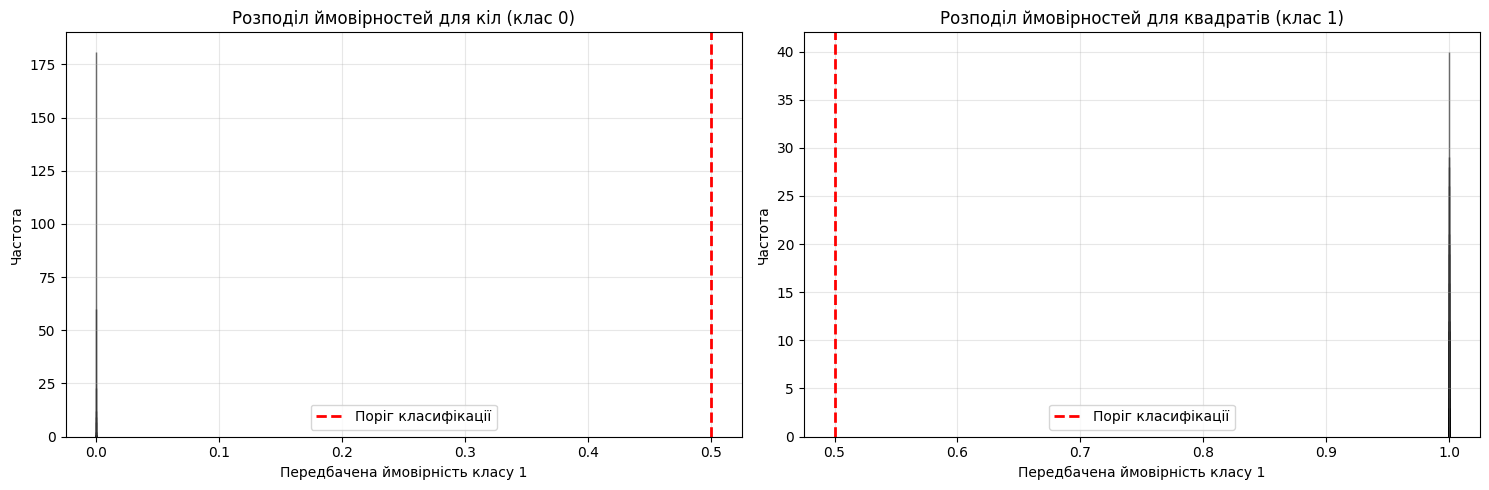

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

probs_class_0 = y_pred_prob[y_test == 0]
axes[0].hist(probs_class_0, bins=50, alpha=0.7, color='blue', edgecolor='black')
axes[0].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Поріг класифікації')
axes[0].set_title('Розподіл ймовірностей для кіл (клас 0)', fontsize=12)
axes[0].set_xlabel('Передбачена ймовірність класу 1')
axes[0].set_ylabel('Частота')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

probs_class_1 = y_pred_prob[y_test == 1]
axes[1].hist(probs_class_1, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[1].axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Поріг класифікації')
axes[1].set_title('Розподіл ймовірностей для квадратів (клас 1)', fontsize=12)
axes[1].set_xlabel('Передбачена ймовірність класу 1')
axes[1].set_ylabel('Частота')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()